# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [33]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

### Знакомство с данными.

In [34]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [36]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [37]:
data.sample(5)

,Unnamed: 0,text,toxic
98825,98921,im sorry it wont happen again,0
20748,20768,Sysop rights \n\nI noticed the discussion of y...,0
120853,120958,"""\n\nI agree. I've moved the whole thing to i...",0
109179,109276,i am sorry to disturb you but you are the only...,0
19791,19811,"""\nArniep: My areas of interest and work are i...",0


Нам предоставленны данные на английском языке. Колонка `Unnamed: 0` неинформативна, избавимся от нее.

In [38]:
data.drop('Unnamed: 0', axis='columns', inplace=True)

In [39]:
data['text'].duplicated().sum()

0

Повторяющихся текстов в данных не обнаружено.

Проверим целевой признак на баланс классов.

In [40]:
len(data[data['toxic'] == 0])

143106

In [41]:
len(data[data['toxic'] == 1])

16186

Количество "нетоксичных" комментариев практически в 10 раз превышает количество токсичных. Учтем это при построении модели.

### Предобработка текста.

Для построения модели и дальнейшей работы с данными, нам необходимо привести их в векторное представление. Прежде всего текст необходимо токенизировать - разбить текст на отдельные слова и избавиться от ненужных символов, а затем лемматизировать - привести слова к их изначальной форме.

In [42]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [43]:
%%time

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

text_df = data['text'].transform(lambda x: re.sub(r"[^A-Za-z']", ' ', x))
text_df = text_df.transform(lambda x: ' '.join(x.split()))
tokens = text_df.transform(lambda x: nltk.word_tokenize(x))

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


lemmatized_tokens = tokens.transform(lambda x: ' '.join([lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in x]))
corpus = lemmatized_tokens.values

# CPU times: user 16min 11s, sys: 1min 40s, total: 17min 52s
# Wall time: 17min 54s

CPU times: user 19min 9s, sys: 1min 53s, total: 21min 2s
Wall time: 21min 11s


Посмотрим на график с наиболее часто используемыми словами.

In [44]:
list_words = []
lemmatized_tokens.apply(lambda x: [list_words.append(i) for i in x.split()])

fdist = FreqDist([word for word in list_words if word not in stop_words])

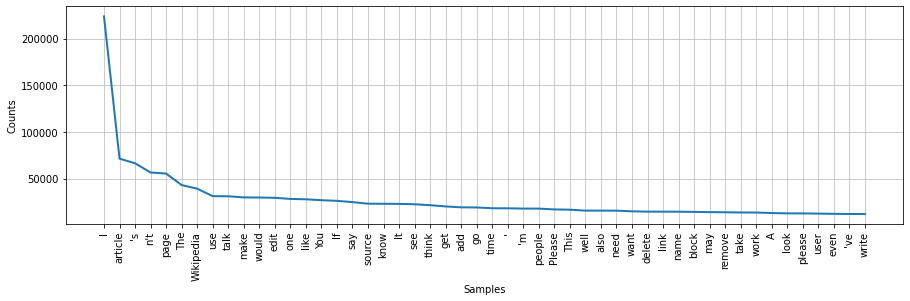

In [45]:
plt.figure(figsize=(15, 4))
fdist.plot(50,cumulative=False)
plt.show()

------

Подготовим признаки на основе оценки важности слов TF-IDF для дальнейшего обучения модели на основе полученного корпуса.

In [14]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

Разделим полученные данные на обучающую и тестовую выборки.

In [15]:
target = data['toxic']

In [16]:
features_train, features_test, target_train, target_test = train_test_split(corpus, target,
                                                                            test_size=0.25, 
                                                                            stratify=target, 
                                                                            random_state=123)

Таким образом на этапе подготовки данных, мы токенизировали и лемматизировали текст с помощью лексической базы WordNet, избавились от стоп-слов и ненужных символов, не несущих смысловой нагрузки. Затем мы создали корпус текстов и перевели корпус в векторное представление для дальнейшего обучения модели. 

В качестве признаков мы решили использовать оценку важности слов TF-IDF.

Также мы отдельно создали выборку для теста лучшей модели, выделив ей 25% данных.

## Обучение

### Модель логистической регрессии.

In [18]:
%%time

text_clf = Pipeline([('tfidf', count_tf_idf),
                    ('clf', LogisticRegression(C=10, class_weight='balanced', max_iter=99999, random_state=123))])

param_grid = {'tfidf__ngram_range': [(1,1), (1,2)]}

lin_grid = GridSearchCV(text_clf, param_grid, scoring='f1', cv=3)
lin_grid.fit(features_train, target_train)

print('Лучший показатель метрики F1 модели линейной регрессии =', lin_grid.best_score_)
print('Лучшие параметры модели:', lin_grid.best_params_)

# Лучший показатель метрики F1 модели линейной регрессии = 0.7740012614192832
# Лучшие параметры модели: {'tfidf__ngram_range': (1, 2)}
# CPU times: user 9min 16s, sys: 7min 59s, total: 17min 16s
# Wall time: 17min 16s

Лучший показатель метрики F1 модели линейной регрессии = 0.7740012614192832
Лучшие параметры модели: {'tfidf__ngram_range': (1, 2)}
CPU times: user 9min 16s, sys: 7min 59s, total: 17min 16s
Wall time: 17min 16s


### Тестирование модели.

Проверим модель логистической регрессии на тестовой выборке.

In [22]:
features_test_vectorized = lin_grid.best_estimator_.named_steps['tfidf'].transform(features_test)
predictions = lin_grid.best_estimator_.named_steps['clf'].predict(features_test_vectorized)
print('Значение метрики F1 на тестовой модели =', f1_score(target_test, predictions))

# Значение метрики F1 на тестовой модели = 0.7824197053851727

Значение метрики F1 на тестовой модели = 0.7824197053851727


Таким образом, значение F1 линейной модели на тестовой выборке составило 0.78.

## Выводы

Задачей исследования являлось создание модели, способной классифицировать комментарии на позитивные и негативные в новом сервисе со свободным редактированием описания товаров интернет-магазина "Викишоп".

Нам были предоствлены данные на английском языке с комментариями и размеченным целевым признаком.

Для построения модели и дальнейшей работы с данными, нам было необходимо привести их в векторное представление. Текст был токенизирован - разбит на отдельные слова и избавлен от ненужных символов, а затем лемматизирован - слова были приведены к их изначальной форме.

Для дальнейшего обучения модели мы подготовили признаки на основе оценки важности слов TF-IDF. Также мы отдельно создали выборку для теста лучшей модели, выделив ей 25% данных.

Наилучшей моделью оказалась модель основанная на алгоритме логистической регрессии, со значением метрики F1 = 0.77, что намного превосходит показатель метрики модели случайного леса (F1 = 0.34).

Было рассмотрено две модели: модель линейной регрессии и модель случайного леса. Наилучший результат показала модель линейной регрессии со значением метрики F1 на тестовой выборке равным 0.78.